/tmp/ipykernel_64240/1833086889.py:19: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(signal1, use_line_collection=True)
/tmp/ipykernel_64240/1833086889.py:23: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(signal2, use_line_collection=True)
/tmp/ipykernel_64240/1833086889.py:28: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(cross_correlati

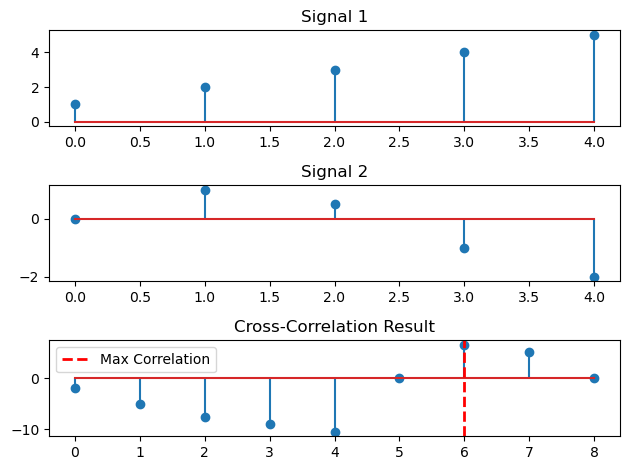

Time Lag (Shift): 2


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Generate two 1D signals
signal1 = np.array([1, 2, 3, 4, 5])
signal2 = np.array([0, 1, 0.5, -1, -2])

# Calculate cross-correlation using numpy.correlate
cross_correlation = np.correlate(signal1, signal2, mode='full')

# Find the index of the maximum correlation
max_correlation_index = np.argmax(cross_correlation)

# Calculate the time lag
time_lag = max_correlation_index - (len(signal1) - 1)

# Plot the original signals
plt.subplot(3, 1, 1)
plt.stem(signal1, use_line_collection=True)
plt.title('Signal 1')

plt.subplot(3, 1, 2)
plt.stem(signal2, use_line_collection=True)
plt.title('Signal 2')

# Plot the cross-correlation result
plt.subplot(3, 1, 3)
plt.stem(cross_correlation, use_line_collection=True)
plt.title('Cross-Correlation Result')

# Highlight the maximum correlation
plt.axvline(max_correlation_index, color='r', linestyle='dashed', linewidth=2, label='Max Correlation')

plt.tight_layout()
plt.legend()
plt.show()

print("Time Lag (Shift):", time_lag)


[[ 1.00000000e+00  0.00000000e+00]
 [ 9.97986676e-01  6.34239197e-02]
 [ 9.91954813e-01  1.26592454e-01]
 [ 9.81928697e-01  1.89251244e-01]
 [ 9.67948701e-01  2.51147987e-01]
 [ 9.50071118e-01  3.12033446e-01]
 [ 9.28367933e-01  3.71662456e-01]
 [ 9.02926538e-01  4.29794912e-01]
 [ 8.73849377e-01  4.86196736e-01]
 [ 8.41253533e-01  5.40640817e-01]
 [ 8.05270258e-01  5.92907929e-01]
 [ 7.66044443e-01  6.42787610e-01]
 [ 7.23734038e-01  6.90079011e-01]
 [ 6.78509412e-01  7.34591709e-01]
 [ 6.30552667e-01  7.76146464e-01]
 [ 5.80056910e-01  8.14575952e-01]
 [ 5.27225468e-01  8.49725430e-01]
 [ 4.72271075e-01  8.81453363e-01]
 [ 4.15415013e-01  9.09631995e-01]
 [ 3.56886222e-01  9.34147860e-01]
 [ 2.96920375e-01  9.54902241e-01]
 [ 2.35758936e-01  9.71811568e-01]
 [ 1.73648178e-01  9.84807753e-01]
 [ 1.10838200e-01  9.93838464e-01]
 [ 4.75819158e-02  9.98867339e-01]
 [-1.58659638e-02  9.99874128e-01]
 [-7.92499569e-02  9.96854776e-01]
 [-1.42314838e-01  9.89821442e-01]
 [-2.04806668e-01  9

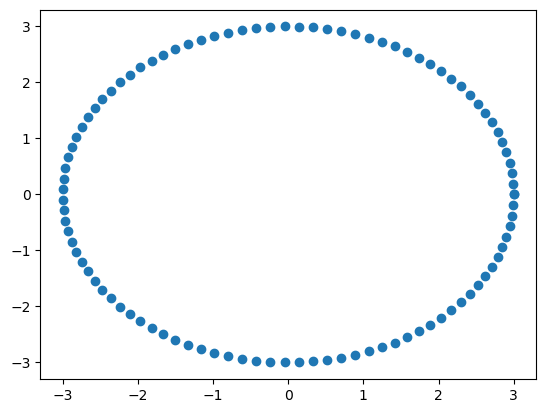

In [9]:
projection_data = np.column_stack([3*np.cos(theta), 3*np.sin(theta)])
fig,ax = plt.subplots()
ax.scatter(projection_data[:,0], projection_data[:,1])

diff = projection_data/np.array([3, 3])


# diff = rotated_data / np.array([major_axis_est, minor_axis_est])
#     return np.sum((diff**2 - 1)**2)